In [34]:
import gurobipy as gp
from gurobipy import GRB

# Time and demand settings
tau = 0.25
T = 60.0
N = int(T / tau)
D_EV = 36.0
D_ICV = 36.0

# Flow parameters
V = 900.0
W = 450.0
K = 0.12
Q_a = (K * V * W / (V + W))*tau

# Link lengths
length = {1: 0.0, 2: 900.0, 3: 1800.0, 4: 900.0, 5: 3600.0, 6: 900.0, 7: 0.0}
travelV = {a: int((length[a]/V)/tau + 1e-9) for a in length} #dividiamo per tau così invece che avere il tempo di percorrrenza abbiamo quanti step ci vogliono per percorrere
travelW = {a: int((length[a]/W)/tau + 1e-9) for a in length}

# Battery parameters
omega = 0.33
epsilon = 1.8e-4
B_max = 0.5
B0 = 0.35

# Budget constraint
I_budget = 2700.0

# Network topology
E = [1, 2, 3, 4, 5, 6, 7]
E_R, E_S, E_A = [1], [7], [2, 3, 4, 5, 6]
pred = {1: [], 2: [1], 3: [1], 4: [2], 5: [2], 6: [3, 4], 7: [5, 6]}
succ = {1: [2, 3], 2: [4, 5], 3: [6], 4: [6], 5: [7], 6: [7], 7: []}

# EV paths
paths = {0: [2, 4, 6], 1: [2, 5], 2: [3, 6]}
delta = {(a, p): int(a in paths[p]) for p in paths for a in E_A}
count_paths = {a: sum(delta[(a, p)] for p in paths) for a in E_A}

model = gp.Model("Dynamic_WCL")
model.setParam("OutputFlag", 0)

x = model.addVars(E_A, vtype=GRB.BINARY, name="x")
y = model.addVars(len(paths), vtype=GRB.BINARY, name="y")
B = {(a, p): model.addVar(ub=B_max, name=f"B_{a}_{p}") for p in paths for a in paths[p]}

classes = ['EV', 'ICV']
u, v, n, f = {}, {}, {}, {}
for m in classes:
    for a in E:
        for i in range(0, N+1):
            u[(m, a, i)] = model.addVar(lb=0.0)
            v[(m, a, i)] = model.addVar(lb=0.0)
            n[(m, a, i)] = model.addVar(lb=0.0)
        for b in pred[a]:
            for i in range(0, N+1):
                f[(m, b, a, i)] = model.addVar(lb=0.0)

alpha = model.addVars(E_A, classes, range(1, N+1), lb=0.0, ub=1.0, name="alpha")
for a in E_A:
    for i in range(1, N+1):
        model.addConstr(gp.quicksum(alpha[a, m, i] for m in classes) == 1.0, name="alphabase")

# Corrected time-weighted objective function (Eq. 1)
model.setObjective(gp.quicksum((T - (i - 1)*tau) *f[(m, b, 7, i)] for m in classes for b in pred[7] for i in range(1, N+1)), GRB.MAXIMIZE)

#model.setObjective(gp.quicksum((N - i + 1) * f[(m, b, 7, i)] for m in classes for b in pred[7] for i in range(1, N+1)),GRB.MAXIMIZE)


model.addConstr(gp.quicksum(length[a] * x[a] for a in E_A) <= I_budget, name="budget")

#upper bound per v e u
#for a in E:
    #for i in range(0,N+1):
        #model.addConstr(gp.quicksum(v[(m,a,i)] for m in classes) <= 2*Q_a,name="upperv")
        #model.addConstr(gp.quicksum(u[(m,a,i)] for m in classes) <= 2*Q_a,name="upperu")


M = B_max + omega * (3600 / V)
#constraints energetiche 4-6
for p, link_list in paths.items():
    for idx, a in enumerate(link_list):
        prevB = B0 if idx == 0 else B[(link_list[idx - 1], p)]
        recharge = omega * (length[a] / V)
        consume = epsilon * length[a]
        model.addConstr(B[(a, p)] <= B_max, name=f"energia1")
        model.addConstr(B[(a, p)] <= prevB - consume + recharge * x[a] + M * (1 - y[p]), name=f"energia2")
        model.addConstr(B[(a, p)] >= prevB - consume + recharge * x[a] - M * (1 - y[p]),name=f"energia3")
        model.addConstr(M* (y[p]-1)<=B[(a,p)],name=f"energia4" )
        



#15 e 18
for i in range(0, N+1):
    model.addConstr(u[('EV', 1, i)] == D_EV,name=f"15EV")
    model.addConstr(u[('ICV', 1, i)] == D_ICV,name=f"15ICV")
    model.addConstr(v[('EV', 7, i)] == 0,name=f"18EV")
    model.addConstr(v[('ICV', 7, i)] == 0,name=f"18ICV")
#16 e 17
for m in classes:
    for a in E:
        for i in range(0, N+1):
            if a not in E_R:
                model.addConstr(u[(m, a, i)]- gp.quicksum(f[(m, b, a, i)] for b in pred[a])==0,name=f"16" )
            if a not in E_S:
                model.addConstr(v[(m, a, i)] - gp.quicksum(f[(m, a, b, i)] for b in succ[a])== 0,name=f"17")
#13 e 14
for m in classes:
    for a in E:
        for i in range(0, N+1):
            inflow = gp.quicksum(u[(m, a, k)] for k in range(0, i+1))  # 12
            outflow = gp.quicksum(v[(m, a, k)] for k in range(0, i+1))
            model.addConstr(n[(m, a, i)]- inflow + outflow==0,name=f"12")
            
            if a in E_A:
                if i >= travelV[a]:
                    model.addConstr(gp.quicksum(u[(m, a, k)] for k in range(max(0,i - travelV[a] + 1),i+1))- n[(m, a, i)]<=0,name=f"13" )

                if i >= travelW[a]:
                    model.addConstr(n[(m, a, i)] + gp.quicksum(v[(m, a, k)] for k in range(max(0,i - travelW[a] + 1), i+1)) <= K * length[a] * alpha[a, m, i],name=f"14")
                    


#20-23
for a in E_A:
    for i in range(0, N+1):
        inflow_s = gp.quicksum(u[(m, a, k)] for m in classes for k in range(0, i))
        outflow_s = gp.quicksum(v[(m, a, k)] for m in classes for k in range(0, i - travelW[a] + 1)) if i > travelW[a] else 0
        supply = K * length[a] + outflow_s - inflow_s
        model.addConstr(gp.quicksum(u[(m, a, i)] for m in classes) <= Q_a,name=f"20")
        model.addConstr(gp.quicksum(u[(m, a, i)] for m in classes) <= supply,name=f"21")

        inflow_d = gp.quicksum(v[(m, a, k)] for m in classes for k in range(0, i))
        outflow_d = gp.quicksum(u[(m, a, k)] for m in classes for k in range(0, i - travelV[a] + 1)) if i > travelV[a] else 0
        demand = outflow_d - inflow_d
        model.addConstr(gp.quicksum(v[(m, a, i)] for m in classes) <= Q_a,name=f"22")
        model.addConstr(gp.quicksum(v[(m, a, i)] for m in classes) <= demand,name=f"23")
#19
for m in classes:
    for a in E_A:
        for i in range(0, N+1):
            inflow = gp.quicksum(f[(m, b, a, i)] for b in pred[a])
            if m == 'EV':
                model.addConstr(inflow <= Q_a * gp.quicksum(delta[(a, p)] * y[p] for p in paths),name=f"19EV")
            else:
                model.addConstr(inflow <= Q_a *count_paths[a], name=f"19ICV")




##### constraint suggerite per alpha
for i in range(1, N+1):
    for a in E_A:
        model.addConstr(gp.quicksum(f[('EV', b, a, i)] for b in pred[a]) <= Q_a * alpha[a, 'EV', i],name=f"alpha1")
        model.addConstr(gp.quicksum(f[('ICV', b, a, i)] for b in pred[a]) <= Q_a * alpha[a, 'ICV', i],name=f"alpha2")
        model.addConstr(alpha[a, 'EV', i] <= gp.quicksum(delta[(a, p)] * y[p] for p in paths),name=f"alpha3")

for p in paths:
    for idx, a in enumerate(paths[p]):
        for i in range(N+1):
            for b in pred[a]:
                model.addConstr(f[('EV', b, a, i)] <= Q_a * y[p],name=f"const")
                # Vincolo MANCANTE: limitazione capacità per classe
#for a in E_A:
    #for i in range(N+1):
        #model.addConstr(gp.quicksum(f[('EV',b,a,i)] for b in pred[a]) <= Q_a * tau * gp.quicksum(delta[a,p]*y[p] for p in paths),name=f"capacity_EV_{a}_{i}")
        #model.addConstr(gp.quicksum(f[('ICV',b,a,i)] for b in pred[a]) <= Q_a * tau,name=f"capacity_ICV_{a}_{i}")



#paths_through_a = {a: [p for p in paths if a in paths[p]] for a in E_A}
# {2: [0, 1], 3: [2], 4: [0], 5: [1], 6: [0, 2]}
for a in E_A:
    for i in range(1, N+1):
        model.addConstr(alpha[a, "EV", i] <= gp.quicksum(y[p] for p in paths if delta[(a,p)]==1),name="nonso")
        
model.optimize()




In [35]:
if model.status == GRB.OPTIMAL:
    print(f"\n=== Objective value: {model.ObjVal:.2f} ===")

    print("\n--- WCL Installations ---")
    for a in E_A:
        if x[a].X > 0.5:
            print(f"WCL installed on arc {a} (length = {length[a]})")

    print("\n--- Feasible EV Paths ---")
    for p in paths:
        if y[p].X > 0.5:
            print(f"Path {p}: {paths[p]}")

else:
    print("Model did not solve to optimality.")




=== Objective value: 113436.00 ===

--- WCL Installations ---
WCL installed on arc 6 (length = 900.0)

--- Feasible EV Paths ---
Path 0: [2, 4, 6]
Path 2: [3, 6]


In [37]:
for c in model.getConstrs():
    if c.Slack < -1e-6:  # soglia numerica
        print(f"⚠️ Constraint {c.ConstrName} violated with slack = {c.Slack:.6f}")


⚠️ Constraint energia3 violated with slack = -1.632000
⚠️ Constraint energia3 violated with slack = -2.468000


In [38]:
constr = model.getConstrByName(f"15ICV")
print(f"Slack: {constr.Slack:.4f}")

Slack: 0.0000


In [39]:
print("\n🔍 ANALISI SLACK CONSTRAINTS\n")

for c in model.getConstrs():
    slack = c.Slack
    name = c.ConstrName
    if abs(slack) < 1e-6:
        status = "ACTIVE (tight)"
    else:
        status = f"Slack = {slack:.4f}"
    print(f"{name}: {status}")


🔍 ANALISI SLACK CONSTRAINTS

alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabase: ACTIVE (tight)
alphabas

In [40]:
from collections import defaultdict

families = defaultdict(list)

for c in model.getConstrs():
    name = c.ConstrName
    slack = c.Slack
    if name:  # ignora vincoli anonimi
        family = name.split("_")[0]
        families[family].append(abs(slack))

for fam, slacks in families.items():
    n_tight = sum(1 for s in slacks if s < 1e-6)
    print(f"🔍 {fam}: {n_tight}/{len(slacks)} tight ({100 * n_tight / len(slacks):.1f}%)")


🔍 alphabase: 1200/1200 tight (100.0%)
🔍 budget: 0/1 tight (0.0%)
🔍 energia1: 0/7 tight (0.0%)
🔍 energia2: 5/7 tight (71.4%)
🔍 energia3: 5/7 tight (71.4%)
🔍 energia4: 0/7 tight (0.0%)
🔍 15EV: 241/241 tight (100.0%)
🔍 15ICV: 241/241 tight (100.0%)
🔍 18EV: 241/241 tight (100.0%)
🔍 18ICV: 241/241 tight (100.0%)
🔍 17: 2892/2892 tight (100.0%)
🔍 16: 2892/2892 tight (100.0%)
🔍 12: 3374/3374 tight (100.0%)
🔍 13: 2323/2338 tight (99.4%)
🔍 14: 1934/2266 tight (85.3%)
🔍 20: 897/1205 tight (74.4%)
🔍 21: 801/1205 tight (66.5%)
🔍 22: 897/1205 tight (74.4%)
🔍 23: 1192/1205 tight (98.9%)
🔍 19EV: 241/1205 tight (20.0%)
🔍 19ICV: 448/1205 tight (37.2%)
🔍 alpha1: 1200/1200 tight (100.0%)
🔍 alpha2: 895/1200 tight (74.6%)
🔍 alpha3: 240/1200 tight (20.0%)
🔍 const: 482/2169 tight (22.2%)
🔍 nonso: 240/1200 tight (20.0%)


In [41]:
from collections import defaultdict
import numpy as np

slacks_by_family = defaultdict(list)

for c in model.getConstrs():
    if c.ConstrName:
        family = c.ConstrName.split("_")[0]
        slacks_by_family[family].append(abs(c.Slack))

for fam, slacks in slacks_by_family.items():
    arr = np.array(slacks)
    print(f"{fam}: avg slack = {arr.mean():.4f}, std = {arr.std():.4f}, min = {arr.min():.4f}")


alphabase: avg slack = 0.0000, std = 0.0000, min = 0.0000
budget: avg slack = 1800.0000, std = 0.0000, min = 1800.0000
energia1: avg slack = 0.4103, std = 0.0891, min = 0.3060
energia2: avg slack = 0.4543, std = 0.7522, min = 0.0000
energia3: avg slack = 0.5857, std = 0.9527, min = 0.0000
energia4: avg slack = 0.6097, std = 0.7685, min = 0.0260
15EV: avg slack = 0.0000, std = 0.0000, min = 0.0000
15ICV: avg slack = 0.0000, std = 0.0000, min = 0.0000
18EV: avg slack = 0.0000, std = 0.0000, min = 0.0000
18ICV: avg slack = 0.0000, std = 0.0000, min = 0.0000
17: avg slack = 0.0000, std = 0.0000, min = 0.0000
16: avg slack = 0.0000, std = 0.0000, min = 0.0000
12: avg slack = 0.0000, std = 0.0000, min = 0.0000
13: avg slack = 0.0577, std = 0.7186, min = 0.0000
14: avg slack = 13.9766, std = 35.6549, min = 0.0000
20: avg slack = 2.3004, std = 3.9258, min = 0.0000
21: avg slack = 38.7710, std = 68.8096, min = 0.0000
22: avg slack = 2.3004, std = 3.9258, min = 0.0000
23: avg slack = 0.0971, std

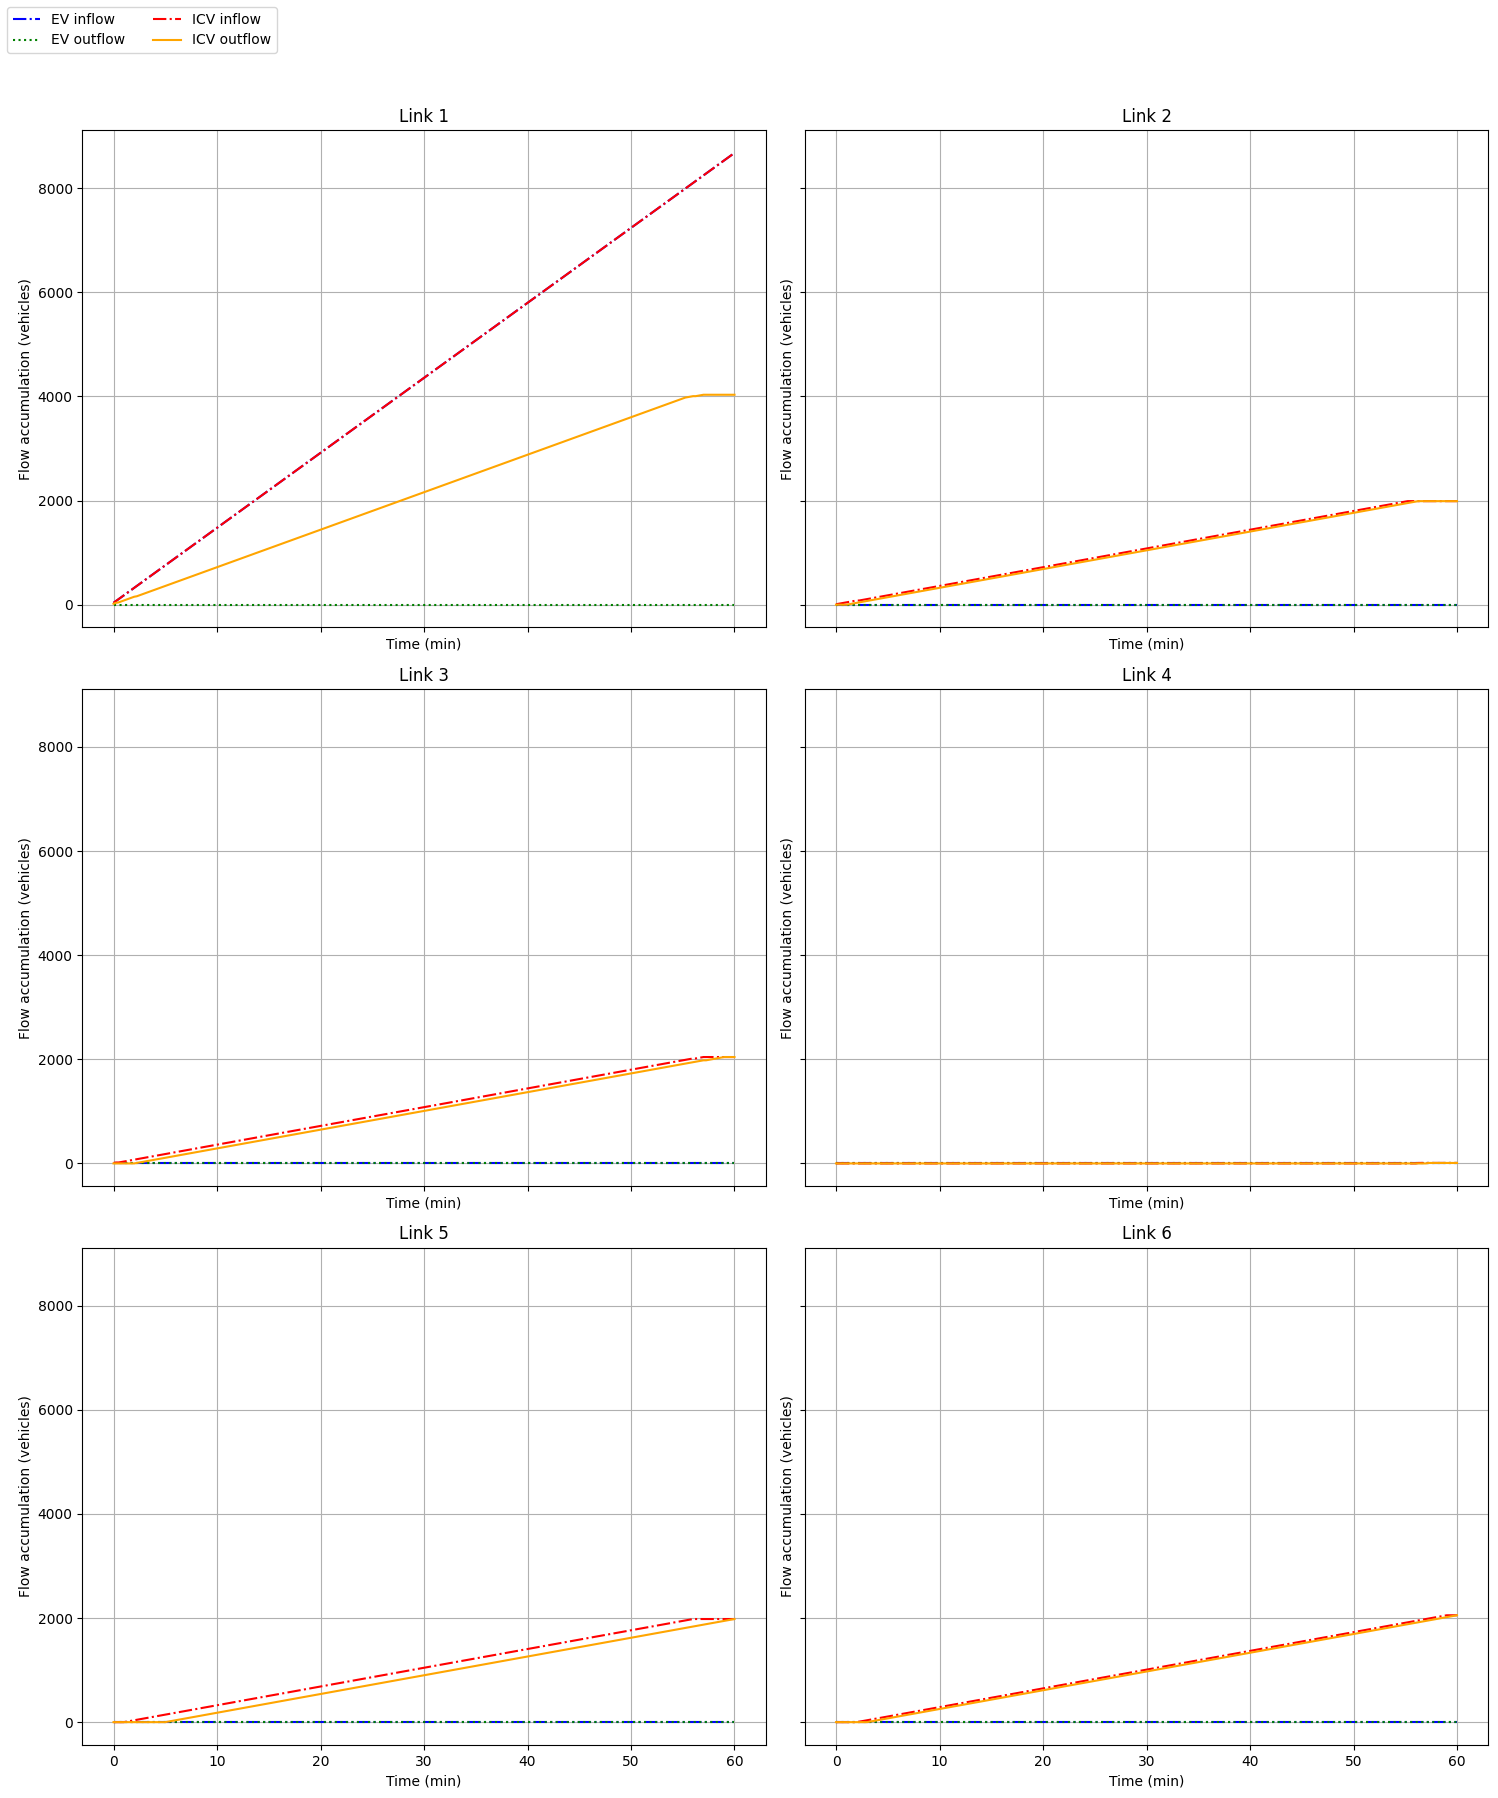

In [42]:
import matplotlib.pyplot as plt
import numpy as np

x_time = [i * tau for i in range(N+1)]

def cumulative_series(values):
    return np.cumsum(values)

#fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), sharex=True, sharey=True)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18), sharex=True, sharey=True)
axes = axes.flatten()

for idx, a in enumerate(E[:-1]):
    ax = axes[idx]

    EV_inflow = [(u[("EV", a, i)].X ) for i in range(N+1)]
    EV_outflow = [(v[("EV", a, i)].X ) for i in range(N+1)]
    ICV_inflow = [(u[("ICV", a, i)].X ) for i in range(N+1)]
    ICV_outflow = [(v[("ICV", a, i)].X ) for i in range(N+1)]

    ax.plot(x_time, cumulative_series(EV_inflow), label="EV inflow", linestyle='dashdot', color='blue')
    ax.plot(x_time, cumulative_series(EV_outflow), label="EV outflow", linestyle='dotted', color='green')
    ax.plot(x_time, cumulative_series(ICV_inflow), label="ICV inflow", linestyle='dashdot', color='red')
    ax.plot(x_time, cumulative_series(ICV_outflow), label="ICV outflow", linestyle='solid', color='orange')

    ax.set_title(f"Link {a}")
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Flow accumulation (vehicles)")
    ax.grid(True)

# Nasconde i plot extra se E_A ha meno di 6 link
for j in range(len(E), len(axes)):
    fig.delaxes(axes[j])

# Una sola legenda comune
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, ncol=2, loc='upper left')
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [49]:
def check_flows_and_alpha_consistency():
    print("\n🔍 [Diagnostica] Verifica coerenza di flussi EV e α")

    flow_inconsistencies = 0
    alpha_inconsistencies = 0

    for a in E_A:
        for i in range(1, N+1):

            # --- [1] Verifica flusso EV coerente con y[p] ---
            inflow = sum(f[('EV', b, a, i)].X for b in pred[a])
            active_paths = [p for p in paths if y[p].X > 0.5 and a in paths[p]]
            if inflow > 1e-4 and not active_paths:
                flow_inconsistencies += 1
                print(f"⚠️ Flusso EV su link {a} a t={i*tau:.2f} min ma nessun path EV attivo lo include.")
                print(f"    → Flusso: {inflow:.2f}")

            # --- [2] Verifica α coerente con path EV attivi ---
            alpha_val = alpha[a, 'EV', i].X
            if alpha_val > 1e-4 and not active_paths:
                alpha_inconsistencies += 1
                print(f"⚠️ α[{a}, EV, {i}] = {alpha_val:.3f} ma nessun y[p]=1 usa questo arco.")
    
    if flow_inconsistencies == 0:
        print("✅ Tutti i flussi EV sono coerenti con i percorsi attivi.")
    else:
        print(f"❌ Trovati {flow_inconsistencies} flussi EV non giustificati da y[p].")

    if alpha_inconsistencies == 0:
        print("✅ Tutti i valori di α[a,EV,i] sono coerenti con i percorsi EV attivi.")
    else:
        print(f"❌ Trovati {alpha_inconsistencies} valori α[a,EV,i] > 0 non giustificati.")
check_flows_and_alpha_consistency()



🔍 [Diagnostica] Verifica coerenza di flussi EV e α
✅ Tutti i flussi EV sono coerenti con i percorsi attivi.
✅ Tutti i valori di α[a,EV,i] sono coerenti con i percorsi EV attivi.


In [48]:
if model.status == GRB.OPTIMAL:
    print("\nAnalisi congestione:")
    for a in E_A:
        total_flow = sum(f[('EV',b,a,i)].X + f[('ICV',b,a,i)].X for b in pred[a] for i in range(1,N+1))
        capacity = Q_a * tau *N
        print(f"Link {a}: Flusso={total_flow:.1f}, Capacità={capacity:.1f}, Utilizzo={total_flow/capacity:.1%}")
        if total_flow > capacity:
            print(f"  ⚠️ Congestione rilevata!")


Analisi congestione:
Link 2: Flusso=1980.0, Capacità=540.0, Utilizzo=366.7%
  ⚠️ Congestione rilevata!
Link 3: Flusso=2034.0, Capacità=540.0, Utilizzo=376.7%
  ⚠️ Congestione rilevata!
Link 4: Flusso=9.0, Capacità=540.0, Utilizzo=1.7%
Link 5: Flusso=1980.0, Capacità=540.0, Utilizzo=366.7%
  ⚠️ Congestione rilevata!
Link 6: Flusso=2052.0, Capacità=540.0, Utilizzo=380.0%
  ⚠️ Congestione rilevata!


In [45]:
total_travel_time = 0.0
for m in classes:
    for a in E:
        for i in range(N+1):
            total_travel_time += n[(m, a, i)].X * tau

print(f"Total Travel Time (EV + ICV): {total_travel_time:.2f} vehicle-minutes")


Total Travel Time (EV + ICV): 524898.00 vehicle-minutes


In [46]:
print("\n🔍 OCCUPAZIONE MAX NEGLI ARCHI")
for a in E_A:
    max_n = max(n[(m, a, i)].X for m in classes for i in range(N+1))
    capacity = K * length[a]
    print(f"Link {a}: Max n = {max_n:.2f} vs Capacity = {capacity:.2f} ({(max_n / capacity) * 100:.1f}%)")



🔍 OCCUPAZIONE MAX NEGLI ARCHI
Link 2: Max n = 45.00 vs Capacity = 108.00 (41.7%)
Link 3: Max n = 72.00 vs Capacity = 216.00 (33.3%)
Link 4: Max n = 9.00 vs Capacity = 108.00 (8.3%)
Link 5: Max n = 144.00 vs Capacity = 432.00 (33.3%)
Link 6: Max n = 36.00 vs Capacity = 108.00 (33.3%)
